# Mechanisms of Action (MoA) Prediction - EDA

In this notebook, we will conduct our initial exploration of the datasets provided in the competition. It is likely that the notebook will evolve as we conduct more experiments, even in the training and testing process.

The competition summary is as follows:

> In this competition, we will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types. In addition, we will have access to Methods of Action (MoA) annotations for more than 5,000 drugs in this dataset.

> Our task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

> Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair. If successful, we’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.


## 1.00 Import Packages

In [2]:
# General packages
import pandas as pd
import numpy as np
from scipy import stats
import os
import gc
import random
from tqdm import tqdm, tqdm_notebook

import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 7]

## 2.00 Read in Data
 - **train_features** - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).
 - **train_targets_scored** - The binary MoA targets that are scored.
 - **train_targets_nonscored** - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.
 - **test_features** - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.
 - **sample_submission** - A submission file in the correct format.

In [3]:
# Directory and file paths
input_dir                    = '../input/lish-moa/'
train_features_path          = os.path.join(input_dir, 'train_features.csv')
test_features_path           = os.path.join(input_dir, 'test_features.csv')
train_targets_nonscored_path = os.path.join(input_dir, 'train_targets_nonscored.csv')
train_targets_scored_path    = os.path.join(input_dir, 'train_targets_scored.csv')
sample_submission_path       = os.path.join(input_dir, 'sample_submission.csv')

# Read in data
train_features          = pd.read_csv(train_features_path)
test_features           = pd.read_csv(test_features_path)
train_targets_nonscored = pd.read_csv(train_targets_nonscored_path)
train_targets_scored    = pd.read_csv(train_targets_scored_path)
sample_submission       = pd.read_csv(sample_submission_path)

del [train_features_path, test_features_path, train_targets_nonscored_path, 
     train_targets_scored_path, sample_submission_path]

print(f'train_features shape: \t\t{train_features.shape}')
print(f'test_features shape: \t\t{test_features.shape}')
print(f'train_targets_nonscored shape: \t{train_targets_nonscored.shape}')
print(f'train_targets_scored shape: \t{train_targets_scored.shape}')
print(f'sample_submission shape: \t{sample_submission.shape}')

train_features shape: 		(23814, 876)
test_features shape: 		(3982, 876)
train_targets_nonscored shape: 	(23814, 403)
train_targets_scored shape: 	(23814, 207)
sample_submission shape: 	(3982, 207)


Highly dimensional, however not too many records. A robust CV strategy will be required as training will be very prone to overfitting. 

## 3.00 Feature Set
The feature set is highly dimensional, and for a well functioning model there'll likely need to be some dimensionality reduction. We'll look for obvious reasons to remove features or combine them, as well as search for any trends in the data in this section.
### 3.01 Feature Set | NA Values
Let's assess the presence of NAs in the feature sets.

In [4]:
print(f'Number of columns with NAs: \
{sum(train_features.isnull().sum() * 100 / len(train_features) > 0)} (train_features)')
print(f'Number of columns with NAs: \
{sum(test_features.isnull().sum() * 100 / len(test_features) > 0)} (test_features)')

Number of columns with NAs: 0 (train_features)
Number of columns with NAs: 0 (test_features)


Thankfully we won't have to deal with *any* NA value handling, which is helpful. 
### 3.02 Feature Set | Column Data Types

In [5]:
# Separate cols into numeric and categorical (minus id columns)
train_cols_numeric = train_features.drop('sig_id', axis=1).select_dtypes('number').columns
train_cols_object  = train_features.drop('sig_id', axis=1).select_dtypes('object').columns

print(f'Number of numeric columns: \t{len(train_cols_numeric)} (train_features)')
print(f'Number of object columns: \t{len(train_cols_object)}   (train_features)')

del train_cols_numeric, train_cols_object

Number of numeric columns: 	873 (train_features)
Number of object columns: 	2   (train_features)


### 3.03 Feature Set | Object Columns
There are only 2 object columns, so we'll take a look at these first. 

In [6]:
print(f"Object column names: {list(train_features.drop('sig_id', axis=1).select_dtypes('object').columns)}")

Object column names: ['cp_type', 'cp_dose']


Based on competition information, `cp_type` indicates samples treated with a compound or with a control perturbation. They also suggest that "control perturbations have no Mechanisms of Action". I'm not a domain expert, but this looks like it's saying there will be no labels for records that have control perturbations..?

`cp_dose` is quite clear: it indicates the treatment dose (high or low).

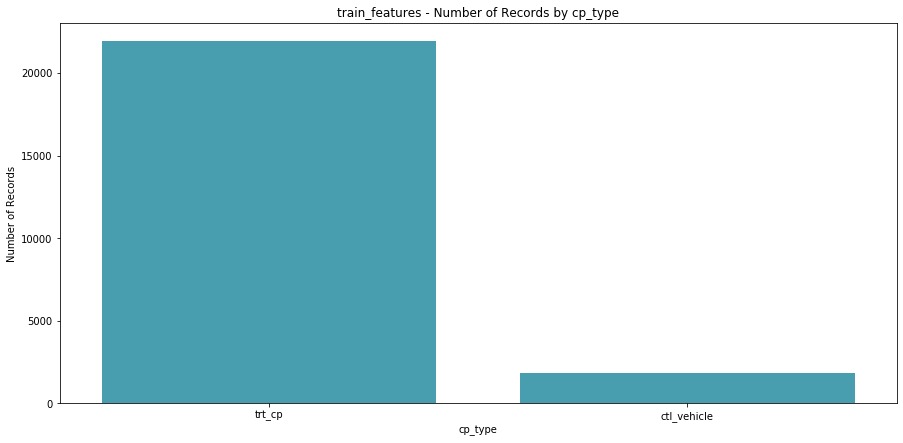

In [7]:
# Plot value counts for 'cp_type' column
sns.barplot(x=train_features['cp_type'].value_counts().index,
            y=train_features['cp_type'].value_counts(),
            color='#37A8BF')
plt.title('train_features - Number of Records by cp_type')
plt.xlabel('cp_type')
plt.ylabel('Number of Records')
plt.show()

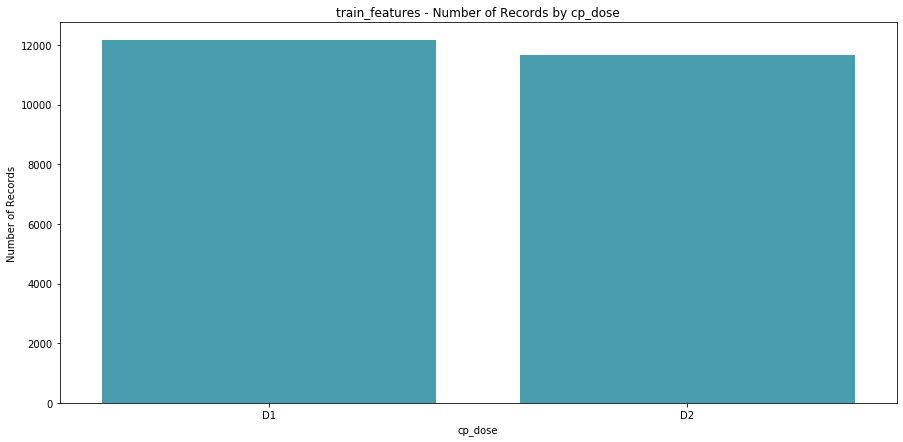

In [8]:
# Plot value counts for 'cp_dose' column
sns.barplot(x=train_features['cp_dose'].value_counts().index,
            y=train_features['cp_dose'].value_counts(),
            color='#37A8BF')
plt.title('train_features - Number of Records by cp_dose')
plt.xlabel('cp_dose')
plt.ylabel('Number of Records')
plt.show()

For our two categorical features, they each have 2 values. This would mean that one-hot-encoding them could be a good way forward. 

`cp_type` is very imbalanced, and `cp_dose` is the opposite.

Initial thoughts are whether there are records with no labels, and whether these records have `cp_type` values of `ctl_vehicle`. 

Also, I imagine the interaction of the `cp_dose` with other features is significant, because alone it doesn't look like it is an important feature.

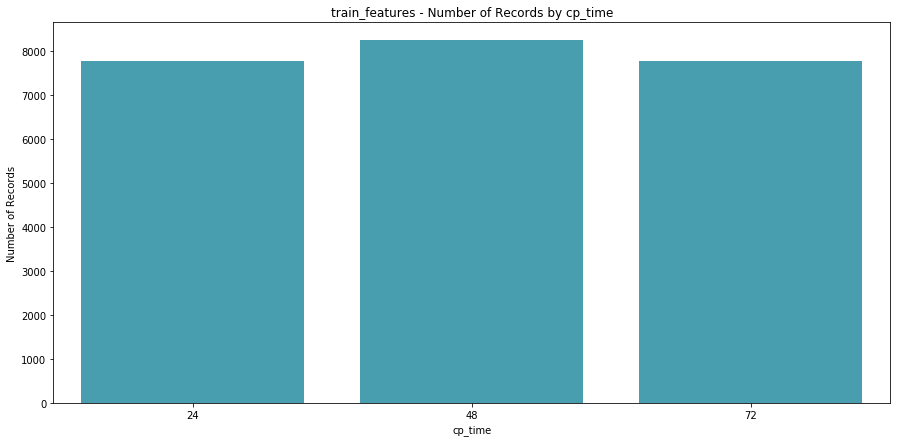

In [9]:
# Plot value counts for 'cp_dose' column
sns.barplot(x=train_features['cp_time'].value_counts().index,
            y=train_features['cp_time'].value_counts(),
            color='#37A8BF')
plt.title('train_features - Number of Records by cp_time')
plt.xlabel('cp_time')
plt.ylabel('Number of Records')
plt.show()

`cp_time` only has 3 values (24, 48, 72) and corresponds to the treatment duration. Similar to cp_dose, I imagine there is more significance held in the interactions with other features than just by itself. 

### 3.04 Feature Set | G- and C- Features
`g-` features signify gene expression data, and `c-` features signify cell viability data. 

Let's take a quick look at how many gene expression and cell viability features we have.

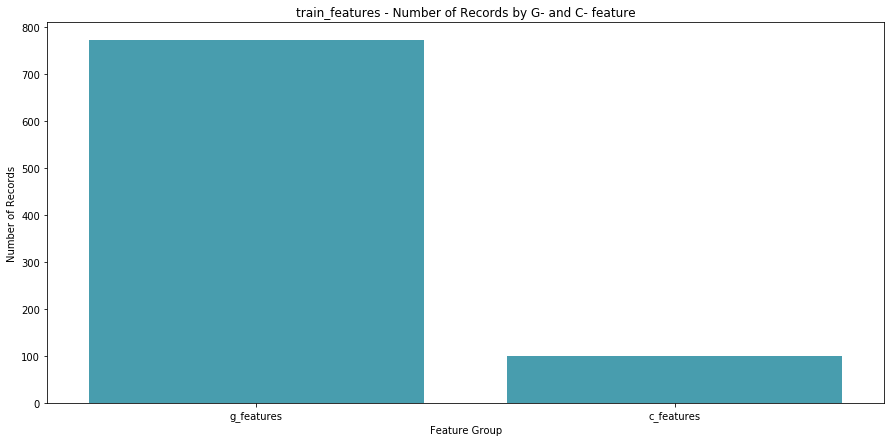

In [10]:
train_features_gc_counts = pd.DataFrame([
    ['g_features', sum(train_features.columns.str.startswith('g-'))],
    ['c_features', sum(train_features.columns.str.startswith('c-'))]],
    columns=['feature','value'])

sns.barplot(x=train_features_gc_counts['feature'],
            y=train_features_gc_counts['value'],
            color='#37A8BF')
plt.title('train_features - Number of Records by G- and C- feature')
plt.xlabel('Feature Group')
plt.ylabel('Number of Records')
plt.show()

del train_features_gc_counts

There's a lot more `g-` features than `c-` features, not equally balanced. I'd be interested to see how models perform with these features separated vs included together. 

Let's take a quick look at distributions of `g-` feature values and `c-` feature values.

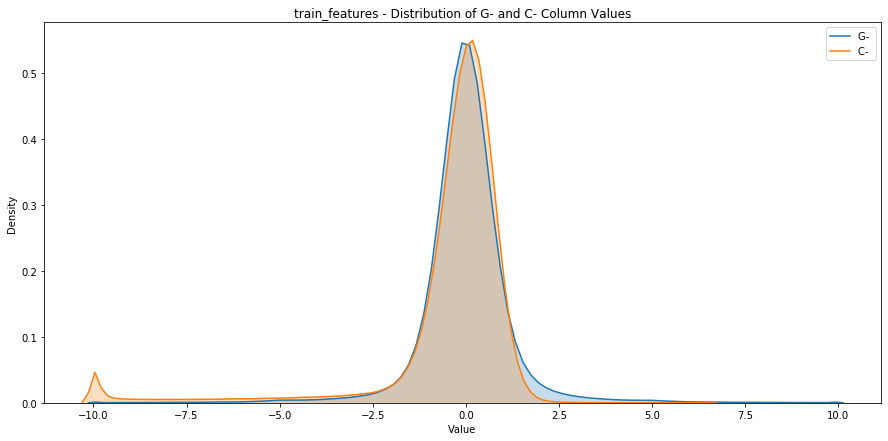

In [11]:
# Plot g- column and c- column value distributions
g_cols = train_features.columns[train_features.columns.str.startswith('g-')]
c_cols = train_features.columns[train_features.columns.str.startswith('c-')]

train_features_g = train_features[g_cols].melt(var_name='label', value_vars=g_cols)
train_features_g['col_group'] = 'g-'
train_features_c = train_features[c_cols].melt(var_name='label', value_vars=c_cols)
train_features_c['col_group'] = 'c-'

sns.kdeplot(train_features_g['value'], shade=True, label='G- ')
sns.kdeplot(train_features_c['value'], shade=True, label='C- ')
plt.title('train_features - Distribution of G- and C- Column Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

del g_cols, c_cols, train_features_g, train_features_c

It looks like the data for both `g-` and `c-` features have already been normalised, I expect using standard scaling given how normally distributed both are around 0. 

Interestingly, it looks like there are some outliers at the lowest end of the scale for `C-` values. There's no way of knowing for certain, but these could have potentially been imputed values to replace NAs (maybe they used a number like 999 or some other value to indicate an NA without explicitly doing so). 

Let's find out where these outlying values originate.

Number of labels that have outliers: 98


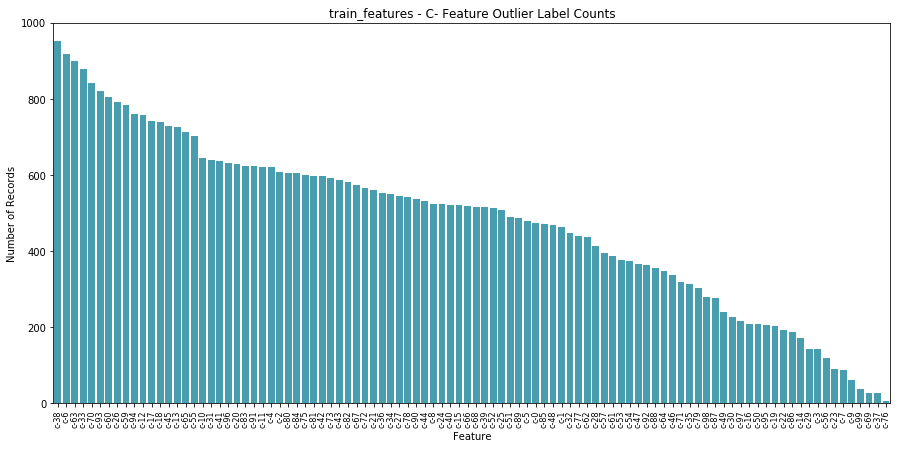

In [12]:
# Plot c- Feature Outlier Label Counts
c_cols = train_features.columns[train_features.columns.str.startswith('c-')]
train_features_outliers = train_features[c_cols]
train_features_outliers = train_features_outliers.melt(var_name='label', value_vars=c_cols)
train_features_outliers = train_features_outliers.loc[train_features_outliers.value <= -9, ]
train_features_outliers = train_features_outliers['label'].value_counts()
train_features_outliers = pd.DataFrame(train_features_outliers)

print(f'Number of labels that have outliers: {len(train_features_outliers)}')

sns.barplot(x=train_features_outliers.index, 
            y=train_features_outliers['label'],
            color='#37A8BF')
plt.title('train_features - C- Feature Outlier Label Counts')
plt.xlabel('Feature')
plt.ylabel('Number of Records')
plt.xticks(rotation=90, fontsize=8)
plt.show()

del c_cols, train_features_outliers

So most `c-` features have these outliers - they're not localised to just one feature. And there doesn't seem to be any trend in which labels have more or less of these outliers either. I'm reluctant to touch these initially as there may be information here that I don't understand. We'll leave them in there for now, and potentially in the modelling stage we can experiment with removing these records vs. leaving them in.

### 3.05 Feature Set | Variances

In [13]:
train_features_var_all = train_features.iloc[:,4:].var(axis=0).describe()
pd.DataFrame(train_features_var_all, columns=['Feature Set - Variances'])

,Feature Set - Variances
count,872.000000
mean,1.733879
std,1.017037
min,0.333275
25%,1.039926
50%,1.390373
75%,2.026995
max,5.326035


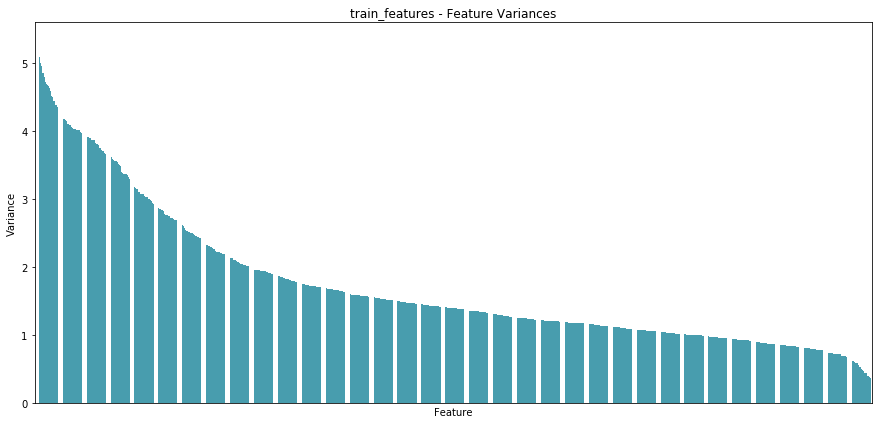

In [14]:
# Plot feature variance
train_features_var_all = train_features.iloc[:,4:].var(axis=0).sort_values(ascending=False)
train_features_var_all = pd.DataFrame(train_features_var_all, columns=['variance'])

sns.barplot(x=train_features_var_all.index, 
            y=train_features_var_all['variance'],
            color='#37A8BF')
plt.title('train_features - Feature Variances')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.tick_params(axis='x', labelbottom=False, bottom=False)
plt.show()

del train_features_var_all

Nothing stands out from the variances of the features - there is a good spread. This is not too surprising given that the data seem to have been standardised. Those features at the higher end of the scale will be the `c-` features with apparent outliers.

## 4.00 Labels
### 4.01 Labels | Numbers

In [15]:
sample_submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,id_00276f245,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,id_0027f1083,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


This is a **multi-label** prediction problem, not a **multi-class**. The difference between these are that the former will not require all probabilities to add up to 1. There can be multiple labels for each record; in other words each label is not mutually exclusive.

We will need to predict the probability for every one of the 206 labels as a stand-alone class.

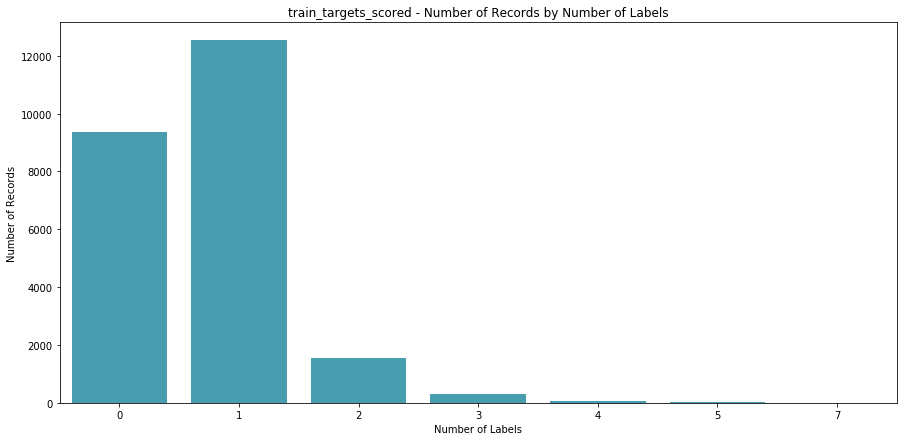

In [16]:
# Plot number of labels by record
sns.barplot(x=train_targets_scored.sum(axis=1).value_counts().sort_values().index,
            y=train_targets_scored.sum(axis=1).value_counts().sort_values(),
            color='#37A8BF')
plt.title('train_targets_scored - Number of Records by Number of Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Records')
plt.show()

So there are ~9,500 records that have 0 labels..? And most only have 1. Let's look at the most and least common labels, before we look at the records with 0 labels.

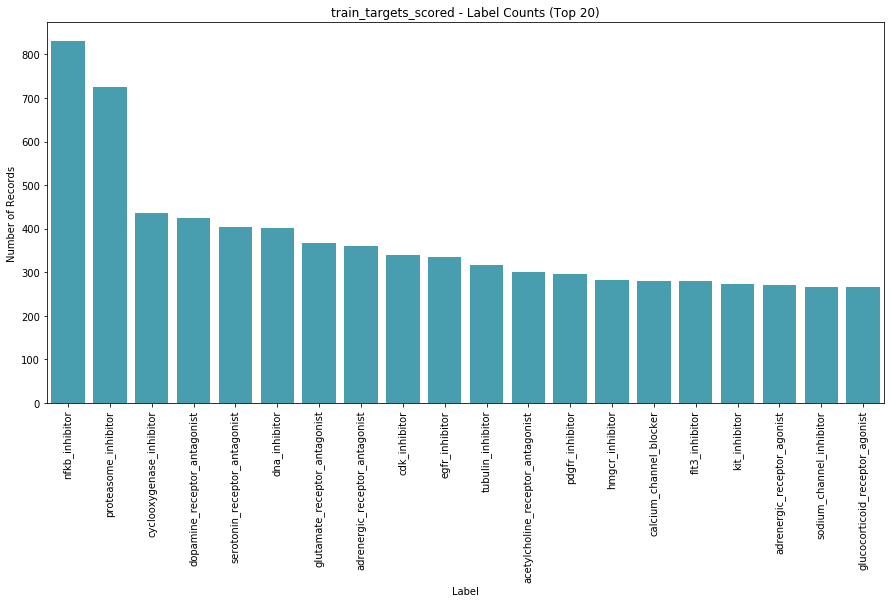

In [17]:
# Plot number of records by label - top 20
sns.barplot(x=train_targets_scored.iloc[:,1:].sum(axis=0).sort_values(ascending=False)[0:20].index,
            y=train_targets_scored.iloc[:,1:].sum(axis=0).sort_values(ascending=False)[0:20],
            color='#37A8BF')
plt.title('train_targets_scored - Label Counts (Top 20)')
plt.xlabel('Label')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)
plt.show()

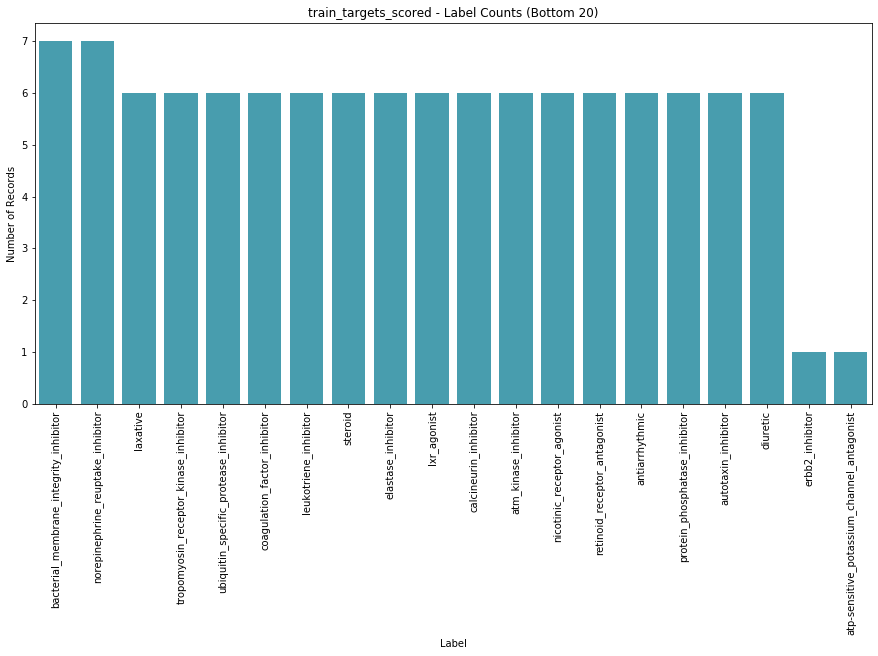

In [18]:
# Plot number of records by label - bottom 20
sns.barplot(x=train_targets_scored.iloc[:,1:].sum(axis=0).sort_values(ascending=False)[-20:].index,
            y=train_targets_scored.iloc[:,1:].sum(axis=0).sort_values(ascending=False)[-20:],
            color='#37A8BF')
plt.title('train_targets_scored - Label Counts (Bottom 20)')
plt.xlabel('Label')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)
plt.show()

There are a few labels that only have records in the single digits. Compared to the labels in the previous plot, this shows quite a high imbalance. Let's look at the entire distribution.

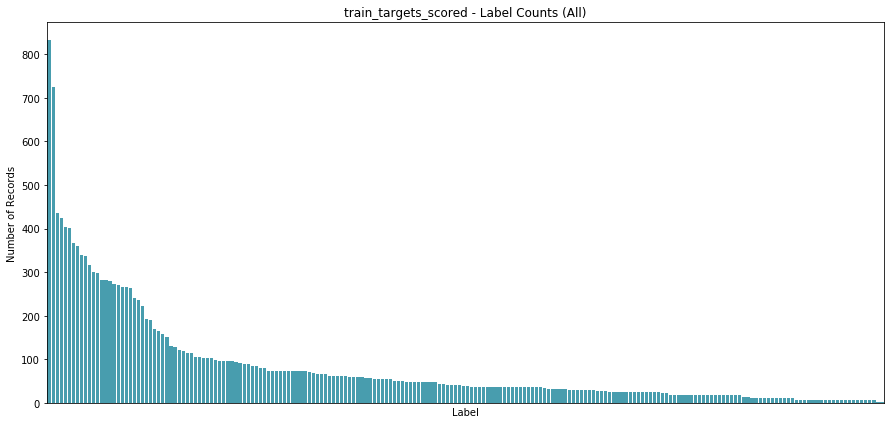

In [19]:
# Plot number of records by label - all
sns.barplot(x=train_targets_scored.iloc[:,1:].sum(axis=0).sort_values(ascending=False).index,
            y=train_targets_scored.iloc[:,1:].sum(axis=0).sort_values(ascending=False),
            color='#37A8BF')
plt.title('train_targets_scored - Label Counts (All)')
plt.xlabel('Label')
plt.ylabel('Number of Records')
plt.tick_params(axis='x', labelbottom=False, bottom=False)
plt.show()

We're going to have to come to terms with data imbalance, particularly since the top 5 or so labels are comparitively very numerous. The model will favour these labels purely due to data availability, and it's likely that it will overfit (or just completely ignore) the labels on the other end of the scale.

Let's output some summary statistics on the numbers of records for labels to support what we're seeing above.

In [20]:
# Summary stats for number of records by label
pd.DataFrame(train_targets_scored.iloc[:,1:].sum(axis=0)
             .describe()).rename(columns={0:'train_targets_scored - Num Records by Label'})

,train_targets_scored - Num Records by Label
count,206.000000
mean,81.766990
std,115.160351
min,1.000000
25%,19.000000
50%,38.500000
75%,83.000000
max,832.000000


A mean of 82 and median of 39, with std of 115 just confirms the large imbalance.

### 4.02 Labels | 0 Label Records
We will investigate the actual label names in more detail shortly, but before that we need to have a look at these records with 0 labels, as these records could just be totally useless, mess up predictions, or play a big part in perfecting the model - it's hard to tell at this point!

There is another file `train_targets_nonscored.csv` that includes extra labels not scored in the competition. These records might belong to that file - let's have a look.

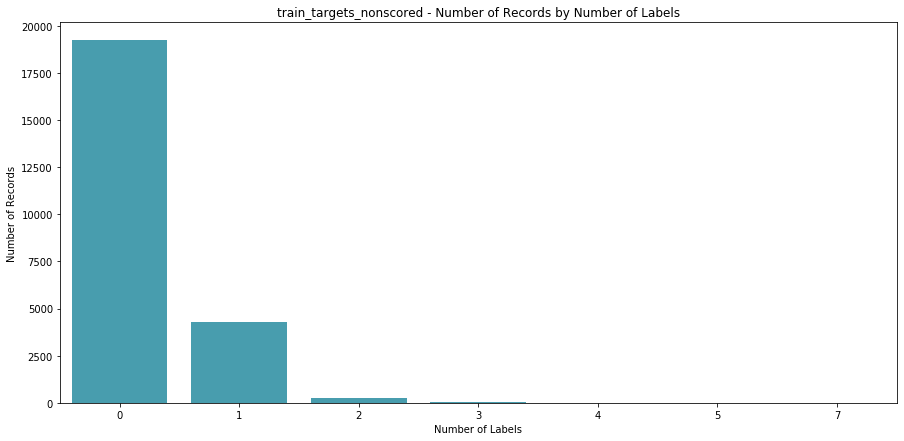

In [21]:
# Plot number of labels by record
sns.barplot(x=train_targets_nonscored.sum(axis=1).value_counts().sort_values().index,
            y=train_targets_nonscored.sum(axis=1).value_counts().sort_values(),
            color='#37A8BF')
plt.title('train_targets_nonscored - Number of Records by Number of Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Records')
plt.show()

So this doesn't really clear things up a whole lot. The majority of records in the train_targets_nonscored file have no labels! 

Let's see if there are any overlaps of labels (column names) between these two files.

In [22]:
# Get colnames for each file excluding record id col
train_targets_nonscored_cols = pd.DataFrame(train_targets_nonscored.columns[1:], columns=['label'])
train_targets_scored_cols = pd.DataFrame(train_targets_scored.columns[1:], columns=['label'])

# Check for overlap between the two files.
col_overlap = pd.merge(train_targets_nonscored_cols, train_targets_scored_cols, on='label')
print(f'There are {len(col_overlap)} shared columns between datasets')

del train_targets_nonscored_cols, train_targets_scored_cols, col_overlap

There are 0 shared columns between datasets


Even more interesting. So there may well be records that have no label at all, in any dataset. Let's double check that all the record ids (column `sig_id`) match in both datasets.

In [23]:
# Get sig_id values for each file
train_targets_nonscored_ids = train_targets_nonscored[['sig_id']]
train_targets_scored_ids = train_targets_scored[['sig_id']]

# Check for overlap between the two files' ids.
ids_overlap = pd.merge(train_targets_nonscored_ids, train_targets_scored_ids, on='sig_id')
print(f'{round(len(ids_overlap) / len(train_targets_scored_ids) * 100, 2)}% of sig_ids match between \
train_targets_nonscored and train_targets_scored')

del train_targets_nonscored_ids, train_targets_scored_ids, ids_overlap

100.0% of sig_ids match between train_targets_nonscored and train_targets_scored


 Now that we know all ids match, we'll merge both datasets together to get all the labels from `train_targets_scored.csv` and `train_targets_nonscored.csv` in one dataframe.

In [24]:
train_targets_all = pd.merge(train_targets_scored, train_targets_nonscored, on='sig_id')
print(f'All train_targets dataframe shape: {train_targets_all.shape}')

All train_targets dataframe shape: (23814, 609)


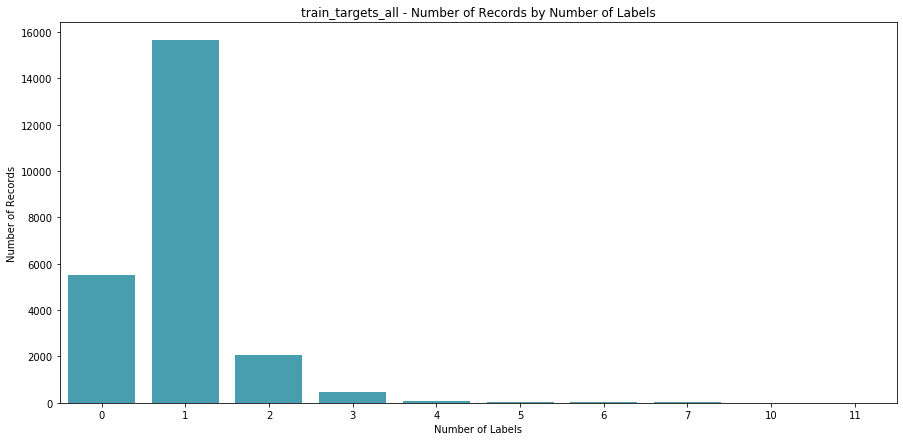

In [25]:
# Plot number of labels by record for all targets
sns.barplot(x=train_targets_all.sum(axis=1).value_counts().sort_values().index,
            y=train_targets_all.sum(axis=1).value_counts().sort_values(),
            color='#37A8BF')
plt.title('train_targets_all - Number of Records by Number of Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Records')
plt.show()

So there are still records with no labels even after we include the full 608 label features. Let's check one more thing before we plan our strategy for handling these records... 

### 4.03 Labels | 0 Label Records Feature Set Analysis 

It was mentioned that records with a `cp_type` value of `ctl_vehicle` (otherwise known as control perturbations) "have no MoAs". So let's find out if the 0 label records correlate with `ctl_vehicle` records.

In [26]:
# Count number of ctl_vehicle records and scored 0 label records to compare
train_features_ctl_vehicle = train_features.loc[train_features.cp_type == 'ctl_vehicle']
train_targets_scored_0_label = train_targets_scored[train_targets_scored.sum(axis=1) == 0]

print(f'Number of ctl_vehicle records: \t\t{train_features_ctl_vehicle.shape[0]}')
print(f'Number of 0 scored label records: \t{train_targets_scored_0_label.shape[0]}')

del train_features_ctl_vehicle, train_targets_scored_0_label

Number of ctl_vehicle records: 		1866
Number of 0 scored label records: 	9367


Not super informative there. What does it look like for the non-scored labels?

In [27]:
# Count number of ctl_vehicle records and non-scored 0 label records to compare
train_features_ctl_vehicle = train_features.loc[train_features.cp_type == 'ctl_vehicle']
train_targets_nonscored_0_label = train_targets_nonscored[train_targets_nonscored.sum(axis=1) == 0]

print(f'Number of ctl_vehicle records: \t\t{train_features_ctl_vehicle.shape[0]}')
print(f'Number of 0 non-scored label records: \t{train_targets_nonscored_0_label.shape[0]}')

del train_features_ctl_vehicle, train_targets_nonscored_0_label

Number of ctl_vehicle records: 		1866
Number of 0 non-scored label records: 	19224


Again, doesn't look like we've found an easy fit. Let's join the scored and non-scored labels together like we did before, and compare the numbers. 

In [28]:
# Count number of ctl_vehicle records and both scored and non-scored 0 label records to compare
train_features_ctl_vehicle = train_features.loc[train_features.cp_type == 'ctl_vehicle']
train_targets_all_0_label = pd.merge(train_targets_scored, train_targets_nonscored, on='sig_id')
train_targets_all_0_label = train_targets_all_0_label[train_targets_all_0_label.sum(axis=1) == 0]

print(f'Number of ctl_vehicle records: \t\t{train_features_ctl_vehicle.shape[0]}')
print(f'Number of 0 non-scored label records: \t{train_targets_all_0_label.shape[0]}')

del train_features_ctl_vehicle, train_targets_all_0_label

Number of ctl_vehicle records: 		1866
Number of 0 non-scored label records: 	5530


So no clear fits by just looking at the numbers. 

Let's plot the correlations for all three label datasets: scored, non-scored and both scored and non-scored. We'll be looking for correlations between 0-label records and `ctl_vehicle` records.

In [29]:
# Create dfs with encoded values for ctl_vehicle and 0 label records for all 3 label datasets
# Then get the pearson-r values for each of the 3 datasets

# Encode scored 0 labels
train_targets_scored_0_label = train_targets_scored[train_targets_scored.sum(axis=1) == 0][['sig_id']]
train_targets_scored_0_label['scored_0_label'] = 1
train_targets_scored_0_label = pd.merge(train_targets_scored[['sig_id']], train_targets_scored_0_label, 
                                        how='left', on='sig_id').fillna(0)
# Encode non-scored 0 labels
train_targets_nonscored_0_label = train_targets_nonscored[train_targets_nonscored.sum(axis=1) == 0][['sig_id']]
train_targets_nonscored_0_label['non_scored_0_label'] = 1
train_targets_nonscored_0_label = pd.merge(train_targets_scored[['sig_id']], train_targets_nonscored_0_label, 
                                           how='left', on='sig_id').fillna(0)
# Encode both scored and non-scored 0 labels
train_targets_all_0_label = pd.merge(train_targets_scored, train_targets_nonscored, on='sig_id')
train_targets_all_0_label = train_targets_all_0_label[train_targets_all_0_label.sum(axis=1) == 0][['sig_id']]
train_targets_all_0_label['all_scored_0_label'] = 1
train_targets_all_0_label = pd.merge(train_targets_scored[['sig_id']], train_targets_all_0_label, 
                                     how='left', on='sig_id').fillna(0)
# Encode cp_type - ctl_vehicle records
train_features_cp_type = train_features[['sig_id','cp_type']]
train_features_cp_type = pd.get_dummies(train_features_cp_type, columns=['cp_type'])
train_features_cp_type = train_features_cp_type.drop('cp_type_trt_cp', axis=1)

# Merge encoded ctl_vehicle records with each of the 3 datasets
train_targets_scored_0_label = pd.merge(train_targets_scored_0_label, train_features_cp_type, 
                                        how='left', on='sig_id')
train_targets_nonscored_0_label = pd.merge(train_targets_nonscored_0_label, train_features_cp_type, 
                                           how='left', on='sig_id')
train_targets_all_0_label = pd.merge(train_targets_all_0_label, train_features_cp_type, 
                                     how='left', on='sig_id')

# Print shapes to ensure merges did not remove records
print(f'Scored labels shape: \t\t{train_targets_scored_0_label.shape}')
print(f'Non-scored labels shape: \t{train_targets_nonscored_0_label.shape}')
print(f'All labels shape: \t\t{train_targets_all_0_label.shape}\n')

# Get pearson-r values for each dataset
train_targets_scored_0_label = stats.pearsonr(train_targets_scored_0_label['scored_0_label'], 
                                              train_targets_scored_0_label['cp_type_ctl_vehicle'])
train_targets_nonscored_0_label = stats.pearsonr(train_targets_nonscored_0_label['non_scored_0_label'], 
                                                 train_targets_nonscored_0_label['cp_type_ctl_vehicle'])
train_targets_all_0_label = stats.pearsonr(train_targets_all_0_label['all_scored_0_label'], 
                                           train_targets_all_0_label['cp_type_ctl_vehicle'])


train_targets_scored_0_label = ['scored_labels', train_targets_scored_0_label[0],
                                train_targets_scored_0_label[1]]
train_targets_nonscored_0_label = ['non_scored_labels', train_targets_nonscored_0_label[0],
                                   train_targets_nonscored_0_label[1]]
train_targets_all_0_label = ['all_labels', train_targets_all_0_label[0],
                             train_targets_all_0_label[1]]


print(pd.DataFrame([train_targets_scored_0_label, train_targets_nonscored_0_label, train_targets_all_0_label],
            columns=['dataset','pearson_r','p_value']))


del train_targets_scored_0_label, train_targets_nonscored_0_label, train_targets_all_0_label

Scored labels shape: 		(23814, 3)
Non-scored labels shape: 	(23814, 3)
All labels shape: 		(23814, 3)

             dataset  pearson_r        p_value
0      scored_labels   0.362115   0.000000e+00
1  non_scored_labels   0.142476  3.281214e-108
2         all_labels   0.530190   0.000000e+00


Correlations don't support the hypothesis.

At this point the best way to deal with these records is unclear, but I have a few ideas of what we can try:
 - Remove them completely, as spurious records. I don't like this option initially, because there may be a way we can use this intricacy to *add* information to our predictions. I don't like removing information from the problem if possible, especially when the dataset is not too large.
 - Analyse the distinction between records with and without labels, to find if there are any features we can add that will help make predictions. Bear in mind we do not have a `test_targets_nonscored.csv` file that we can utilise.  
 - Create an initial classifier to predict records with 0 labels before passing the data into a secondary classifier that only predicts using records *with* labels. 
 - Leave them as they are and proceed with prediction.
 
I like the idea of an initial binary classifier. We'll probably test that out first and evaluate its success.